Demo #5: Anomaly detection using SKF

Import libraries

In [1]:
import sys
import os
from pathlib import Path
# project_root = Path.cwd().parent
# sys.path.append(project_root)
project_root = Path("/Users/vuongdai/GitHub/canari")  
sys.path.append(str(project_root))  

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from examples import DataProcess
from pytagi import Normalizer
import pytagi.metric as metric
import copy

Import components

In [2]:
from src import (
    LocalTrend,
    LocalAcceleration,
    LstmNetwork,
    WhiteNoise,
    Model,
    ModelOptimizer,
    SKF,
    SKFOptimizer,
    plot_data,
    plot_prediction,
    plot_skf_states,
    plot_states,
)

/opt/miniconda3/envs/canari/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2025-03-28 13:08:16,554	INFO util.py:154 -- Missing packages: ['ipywidgets']. Run `pip install -U ipywidgets`, then restart the notebook server for rich notebook output.
2025-03-28 13:08:16,677	INFO util.py:154 -- Missing packages: ['ipywidgets']. Run `pip install -U ipywidgets`, then restart the notebook server for rich notebook output.


Read data

In [3]:
data_file = "/Users/vuongdai/GitHub/canari/data/benchmark_data/test_4_data.csv"
df = pd.read_csv(data_file, skiprows=1, delimiter=",", header=None)
time = pd.to_datetime(df.iloc[:, 0])
df = df.iloc[:, 1:]
df.index = time
df.index.name = "time"
df.columns = ["crack opening", "water_level", "temp_min", "temp_max"]

Data preprocess

In [4]:
output_col = [0]
data_processor = DataProcess(
    data=df,
    time_covariates=["week_of_year"],
    train_split=0.23,
    validation_split=0.07,
    output_col=output_col,
)
train_data, validation_data, test_data, all_data = data_processor.get_splits()
data_processor.data.head()

,crack opening,water_level,temp_min,temp_max,week_of_year
time,,,,,
2010-11-07,6.595455,31.053636,-2.2,3.5,44.0
2010-11-14,6.523333,30.986667,-1.7,9.9,45.0
2010-11-21,6.430000,31.070000,-5.8,1.6,46.0
2010-11-28,6.360000,31.000000,-11.5,0.1,47.0
2010-12-05,6.210000,30.930000,-5.1,-1.1,48.0


Define components

In [5]:
local_trend = LocalTrend()
local_acceleration = LocalAcceleration()
pattern = LstmNetwork(
        look_back_len=51,
        num_features=5, # number of data's columns + time covariates
        num_layer=1,
        num_hidden_unit=50,
        device="cpu",
        manual_seed=1,
    )
residual = WhiteNoise(std_error=0.04746)

Define normal and abnormal models

In [6]:
# Normal model
model = Model(
    local_trend,
    pattern,
    residual,
)

#  Abnormal model
ab_model = Model(
    local_acceleration,
    pattern,
    residual,
)

Define SKF model

In [7]:
# Switching Kalman filter
skf = SKF(
    norm_model=model,
    abnorm_model=ab_model,
    std_transition_error=3.288056287040139e-05,
    norm_to_abnorm_prob=2.8867340936017124e-06,
    abnorm_to_norm_prob=1e-1,
    norm_model_prior_prob=0.99,
)

Train model -- Objective: train LSTM neural network -- skf.lstm_train()

In [8]:
skf.auto_initialize_baseline_states(train_data["y"][0 : 52 * 3])
max_num_epoch = 50
states_optim = None
mu_validation_preds_optim = None
std_validation_preds_optim = None

for epoch in range(max_num_epoch):
    mu_validation_preds, std_validation_preds, states = skf.lstm_train(
        train_data=train_data,
        validation_data=validation_data,
    )

    mu_validation_preds_unnorm = Normalizer.unstandardize(
        mu_validation_preds,
        data_processor.norm_const_mean[data_processor.output_col],
        data_processor.norm_const_std[data_processor.output_col],
    )

    std_validation_preds_unnorm = Normalizer.unstandardize_std(
        std_validation_preds,
        data_processor.norm_const_std[data_processor.output_col],
    )

    validation_obs = data_processor.get_data("validation").flatten()
    validation_log_lik = metric.log_likelihood(
        prediction=mu_validation_preds_unnorm,
        observation=validation_obs,
        std=std_validation_preds_unnorm,
    )

    skf.early_stopping(evaluate_metric=-validation_log_lik, mode="min")

    if epoch == skf.optimal_epoch:
        mu_validation_preds_optim = mu_validation_preds.copy()
        std_validation_preds_optim = std_validation_preds.copy()
        states_optim = copy.copy(states)
    if skf.stop_training:
        break

print(f"Optinal epoch       : {skf.optimal_epoch}")
print(f"Validation MSE      :{skf.early_stop_metric: 0.4f}")

Optinal epoch       : 20
Validation MSE      :-0.8027


Plot predictions

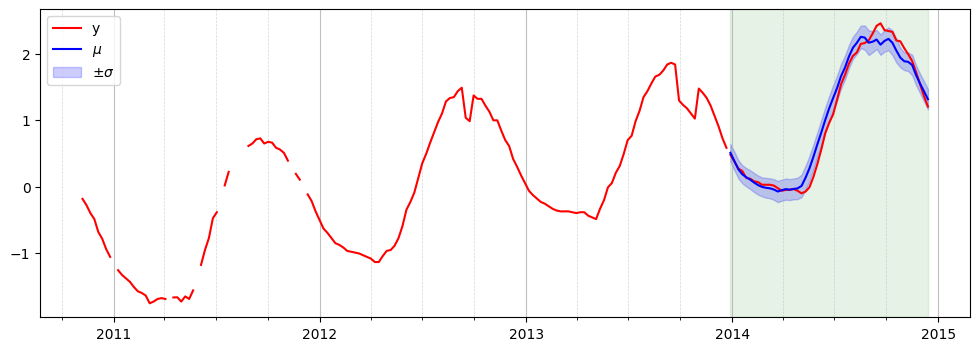

In [9]:
fig, ax = plt.subplots(figsize=(12, 4))
plot_data(
    data_processor=data_processor,
    normalization=True,
    plot_test_data=False,
    plot_column=output_col,
    validation_label="y",
)
plot_prediction(
    data_processor=data_processor,
    mean_validation_pred=mu_validation_preds_optim,
    std_validation_pred=std_validation_preds_optim,
    validation_label=[r"$\mu$", f"$\pm\sigma$"],
)
plt.legend()
plt.show()

Detect anomaly

In [10]:
filter_marginal_abnorm_prob, _ = skf.filter(data=all_data)
smooth_marginal_abnorm_prob, states = skf.smoother(data=all_data)

Plot results

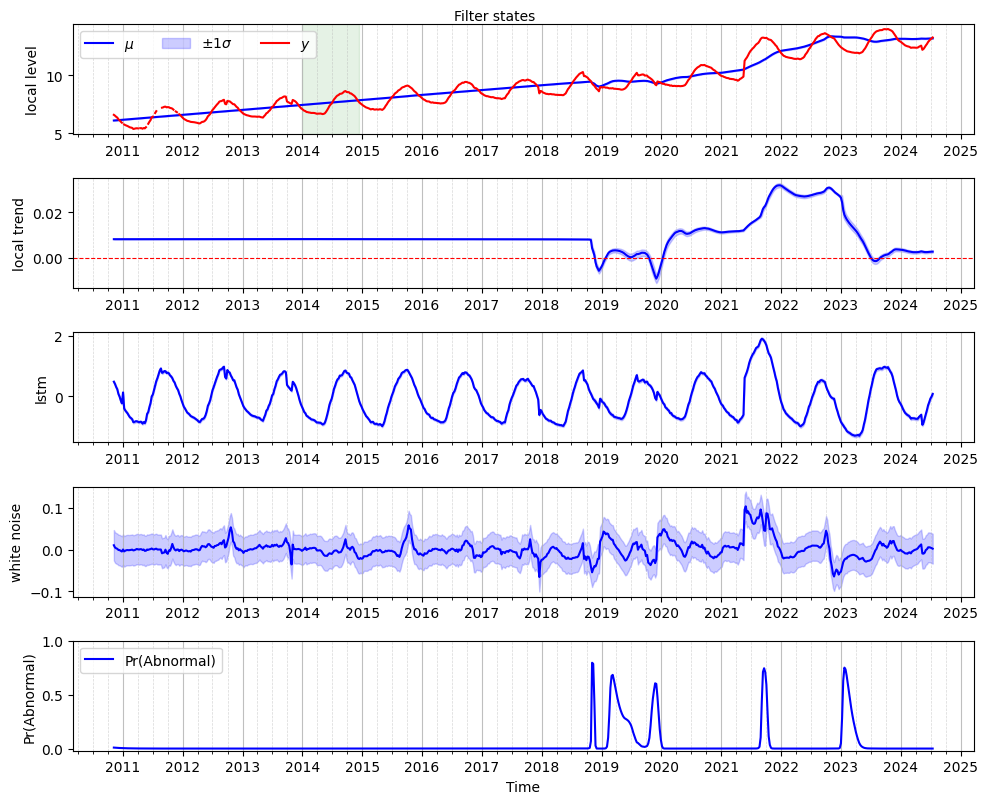

In [11]:
fig, ax = plot_skf_states(
    data_processor=data_processor,
    states=states,
    states_to_plot=["local level", "local trend", "lstm", "white noise"],
    model_prob=filter_marginal_abnorm_prob,
    color="b",
    legend_location="upper left",
)
fig.suptitle("Filter states", fontsize=10, y=1)
plt.show()

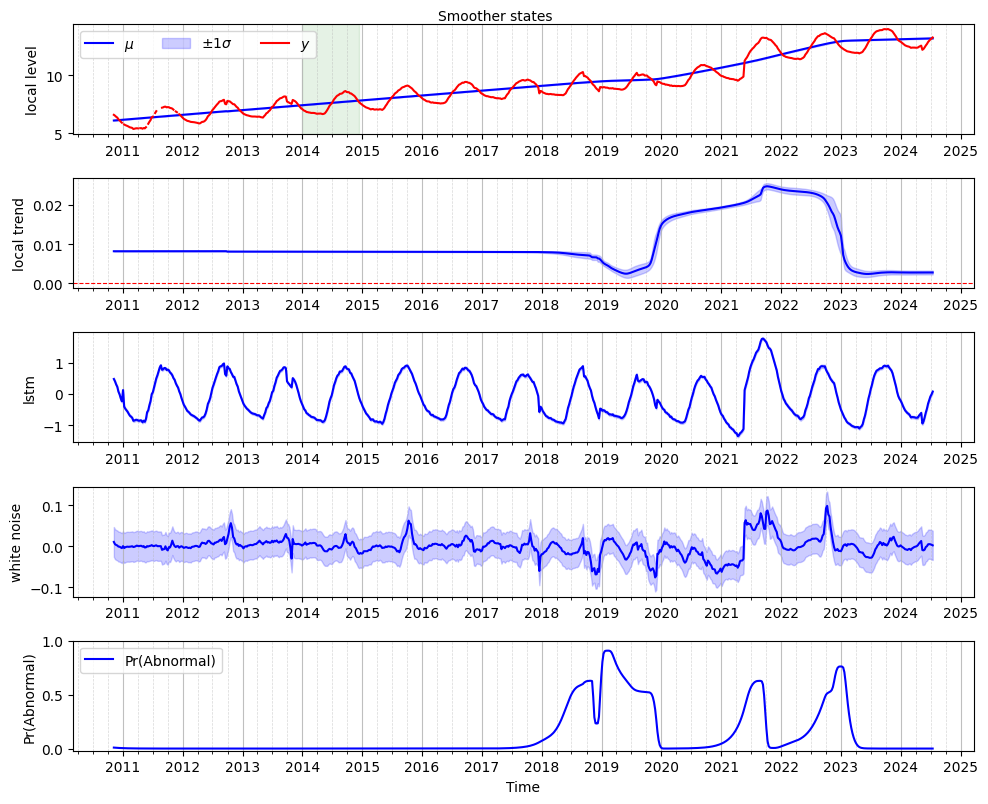

In [12]:
fig, ax = plot_skf_states(
    data_processor=data_processor,
    states=states,
    states_type="smooth",
    states_to_plot=["local level", "local trend", "lstm", "white noise"],
    model_prob=smooth_marginal_abnorm_prob,
    color="b",
    legend_location="upper left",
)
fig.suptitle("Smoother states", fontsize=10, y=1)
plt.show()